# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

Uma aplicação possível desse projeto é como parte de um sistema de verificação de autodeclaração de renda. Esse sistema compararia a renda autodeclarada com a resposta do modelo de machine learning a fim de verificar a integridade desse dado.

Utilizaremos a métrica **MAE** (mean absolute error) para avaliar o nosso modelo. A justificativa para a escolha dessa métrica é que não desejamos penalizar exarcebadamente erros grandes. Preferimos que o nosso modelo seja mais preciso com rendas mais baixas e intermediárias.

## Extração dos dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração será realizada utilizando SQL utilizando a API do **BigQuery**.

In [1]:
# # Consulta

# import os
# import pandas as pd
# from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

# client = bigquery.Client()

# query = """
#         SELECT sigla_uf, situacao_domicilio, v0202 AS tipo_domicilio, v0205 AS condicao_domicilio, v0203 AS comodos, v0204 AS dormitorios,v0209 AS banheiros, v0207 AS agua, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v0212 AS coleta_lixo, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres, v7616 AS rendimento
#         FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
#         WHERE (v7616 IS NOT NULL) AND (v7616 > 0) AND (v7616 < 100000) AND v0201 = 1
#         ORDER BY RAND() 
#         LIMIT 100000;
#         """

# df_raw = client.query(query).to_dataframe()
# df_raw.to_csv('data/df_raw.csv', index=False)

# df_raw.head()

## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
situacao_domicilio | int64 | 1: Urbano, 2: Rural
tipo_domicilio | int64 | 1: Casa, 2: Apartamento, 3: Cômodo
condicao_domicilio | int64 | 1: proprio pago, 2: proprio pagando, 3: alugado, 4: cedido por empregador, 5: cedido, 6: outro
comodos | int64 | Número de cômodos
dormitorios | int64 | Número de dormitórios
banheiros | int64 | Número de banheiros
agua | int64 | Abastecimento de água, (1: rede geral, 2: Poço, 3: outro)
iluminacao | int64 | Existência de ilimunação elétrica (1: sim, 2: não)
radio | int64 | Existência de rádios (1: Sim, 2: Não)
geladeira | int64 | Existência de geladeira (1: Sim, 2: Não)
videocassete | int64 | Existência de videocassete (1: Sim, 2: Não)
maquina_lavar | int64 | Existência de máquinas de lavar (1: Sim, 2: Não)
microondas | int64 | Existência de microondas (1: Sim, 2: Não)
telefone | int64 | Existência de linhas telefônicas (1: Sim, 2: Não)
computador | int64 | Existência de computadores (1: Sim, 2: Não)
televisores | int64 | Número de televisores
automoveis | int64 | Número de automoveis 
ar_condicionado | int64 | Número de ar-condicionado
coleta_lixo | int64 | 1: serviço de limpeza, 2: caçamba, 3: queimado, 4: enterrado, 5: aterro, 6: rio, 7: outro
moradores | int64 | Número de moradores
homens | int64 | Número de homens residentes
mulheres | int64 | Número de mulheres residentes
rendimento | int64 | Total de rendimentos (Target)

## Explorando os dados

In [32]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from skopt import dummy_minimize, gp_minimize

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
df_raw = pd.read_csv('data/df_raw.csv')

In [4]:
df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
0,CE,1,1,1,3,2,0,2,1,1,...,2,2,1,0,0,5,5,3,2,240
1,GO,1,1,1,6,3,1,1,1,1,...,1,2,1,0,0,1,3,1,2,660
2,SP,1,2,1,5,2,1,1,1,1,...,1,1,2,1,0,1,3,1,2,3100
3,SP,1,1,1,6,2,1,1,1,1,...,1,1,2,0,0,1,6,1,5,1980
4,PE,1,1,1,4,2,1,1,1,2,...,2,2,1,0,0,1,13,4,9,391


In [5]:
df_raw.shape

(100000, 24)

In [6]:
df_raw.isna().sum()

sigla_uf              0
situacao_domicilio    0
tipo_domicilio        0
condicao_domicilio    0
comodos               0
dormitorios           0
banheiros             0
agua                  0
iluminacao            0
radio                 0
geladeira             0
videocassete          0
maquina_lavar         0
microondas            0
telefone              0
computador            0
televisores           0
automoveis            0
ar_condicionado       0
coleta_lixo           0
moradores             0
homens                0
mulheres              0
rendimento            0
dtype: int64

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sigla_uf            100000 non-null  object
 1   situacao_domicilio  100000 non-null  int64 
 2   tipo_domicilio      100000 non-null  int64 
 3   condicao_domicilio  100000 non-null  int64 
 4   comodos             100000 non-null  int64 
 5   dormitorios         100000 non-null  int64 
 6   banheiros           100000 non-null  int64 
 7   agua                100000 non-null  int64 
 8   iluminacao          100000 non-null  int64 
 9   radio               100000 non-null  int64 
 10  geladeira           100000 non-null  int64 
 11  videocassete        100000 non-null  int64 
 12  maquina_lavar       100000 non-null  int64 
 13  microondas          100000 non-null  int64 
 14  telefone            100000 non-null  int64 
 15  computador          100000 non-null  int64 
 16  tel

In [8]:
df_raw.describe()

,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.202240,1.105470,1.76498,5.726380,2.029350,1.100360,1.318370,1.060910,1.123140,1.174680,...,1.631690,1.902770,1.278220,0.400540,0.107030,1.77741,3.854170,1.905220,1.948950,1080.996760
std,0.401672,0.339186,1.29282,2.364358,0.872466,0.824169,0.595411,0.239166,0.328599,0.379695,...,0.482348,0.296272,0.898444,0.651945,0.472924,1.40638,1.952501,1.273127,1.215565,2119.736992
min,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,3.000000
25%,1.000000,1.000000,1.00000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,286.000000
50%,1.000000,1.000000,1.00000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,512.000000
75%,1.000000,1.000000,2.00000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,1.000000,0.000000,2.00000,5.000000,3.000000,3.000000,1091.250000
max,2.000000,3.000000,6.00000,30.000000,9.000000,9.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,9.000000,9.000000,9.000000,7.00000,27.000000,14.000000,17.000000,99072.000000


## Pre-processamento

In [9]:
def preprocessing(df_raw):
    df = df_raw.copy()
    df['situacao_domicilio'] = df_raw['situacao_domicilio'].map({1:'urbano', 2:'rural'})
    df['tipo_domicilio'] = df_raw['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})
    df['condicao_domicilio'] = df_raw['condicao_domicilio'].map({1:'proprio pago',
                                                             2:'proprio pagando',
                                                             3:'alugado',
                                                             4:'cedido por empregador',
                                                             5:'cedido',
                                                             6:'outro'})
    df['agua'] = df_raw['agua'].map({1:'rede geral',
                                 2:'poço',
                                 3:'outro'})
    df['iluminacao'] = df_raw['iluminacao'].map({1:'sim',
                                             2:'não'})
    df['radio'] = df_raw['radio'].map({1:'sim',
                                   2:'não'})
    df['geladeira'] = df_raw['geladeira'].map({1:'sim',
                                           2:'não'})
    df['videocassete'] = df_raw['videocassete'].map({1:'sim',
                                                 2:'não'})
    df['maquina_lavar'] = df_raw['maquina_lavar'].map({1:'sim',
                                                   2:'não'})
    df['microondas'] = df_raw['microondas'].map({1:'sim',
                                             2:'não'})
    df['telefone'] = df_raw['telefone'].map({1:'sim',
                                         2:'não'})
    df['computador'] = df_raw['computador'].map({1:'sim',
                                             2:'não'})
    df['coleta_lixo'] = df_raw['coleta_lixo'].map({1:'serviço de limpeza',
                                               2:'caçamba',
                                               3:'queimado',
                                               4:'enterrado',
                                               5:'aterro',
                                               6:'rio',
                                               7:'outro'})
    return df
    

In [10]:
df = preprocessing(df_raw)

In [11]:
df.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
0,CE,urbano,casa,proprio pago,3,2,0,poço,sim,sim,...,não,não,1,0,0,aterro,5,3,2,240
1,GO,urbano,casa,proprio pago,6,3,1,rede geral,sim,sim,...,sim,não,1,0,0,serviço de limpeza,3,1,2,660
2,SP,urbano,apartamento,proprio pago,5,2,1,rede geral,sim,sim,...,sim,sim,2,1,0,serviço de limpeza,3,1,2,3100
3,SP,urbano,casa,proprio pago,6,2,1,rede geral,sim,sim,...,sim,sim,2,0,0,serviço de limpeza,6,1,5,1980
4,PE,urbano,casa,proprio pago,4,2,1,rede geral,sim,não,...,não,não,1,0,0,serviço de limpeza,13,4,9,391


Antes de fazer o split dos dados, vamos analisar o target para fazer amostras estratificadas.

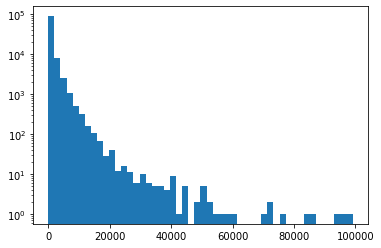

In [12]:
# Checando target. Escala semilog para facilitar a visulização.

plt.hist(df.rendimento, bins=50, log=True)
plt.show()

In [13]:
df.rendimento.describe()

count    100000.000000
mean       1080.996760
std        2119.736992
min           3.000000
25%         286.000000
50%         512.000000
75%        1091.250000
max       99072.000000
Name: rendimento, dtype: float64

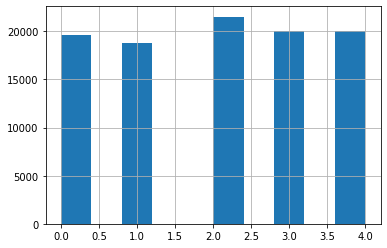

In [14]:
from sklearn.preprocessing import KBinsDiscretizer

kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

df["rendimento_cat"] = kbins.fit_transform(df.rendimento.to_numpy().reshape(-1, 1))

df["rendimento_cat"].hist()
plt.show()

In [15]:
# Checando os bins criados

kbins.bin_edges_

array([array([3.0000e+00, 2.2000e+02, 4.0000e+02, 7.0000e+02, 1.3200e+03,
              9.9072e+04])                                               ],
      dtype=object)

In [16]:
# Train test split

train_val, test = train_test_split(df, test_size=0.2, stratify=df.rendimento_cat, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val.rendimento_cat, random_state=42)

X_train = train.drop(['rendimento', 'rendimento_cat'], axis=1)
y_train = train['rendimento']

X_val = val.drop(['rendimento', 'rendimento_cat'], axis=1)
y_val = val['rendimento']

X_test = test.drop(['rendimento', 'rendimento_cat'], axis=1)
y_test = test['rendimento']

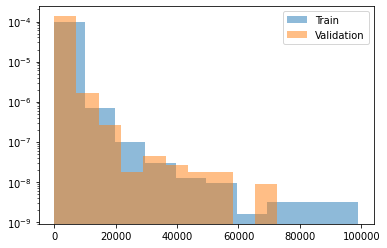

In [17]:
plt.hist(y_train, density=True, log=True, alpha=0.5, label='Train')
plt.hist(y_val, density=True, log=True, alpha=0.5, label='Validation')
plt.legend()
plt.show()

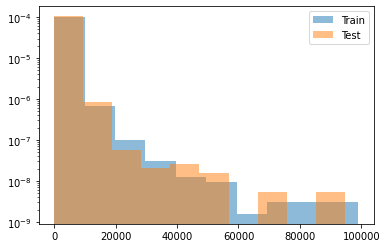

In [18]:
plt.hist(y_train, density=True, log=True, alpha=0.5, label='Train')
plt.hist(y_test, density=True, log=True, alpha=0.5, label='Test')
plt.legend()
plt.show()

In [19]:
print(f'train: {y_train.shape[0]}, validation: {y_val.shape[0]}, test: {y_test.shape[0]}')

train: 64000, validation: 16000, test: 20000


## EDA

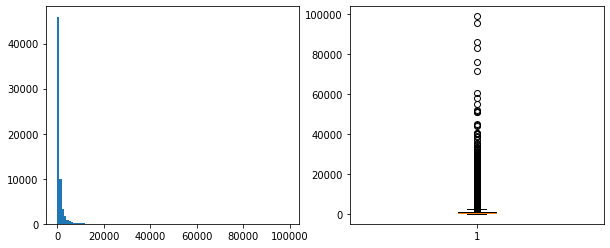

In [20]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_train, bins=100)

plt.subplot(1,2,2)
plt.boxplot(y_train)

plt.show()

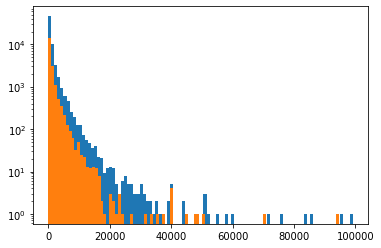

In [23]:
plt.hist(y_train, bins=100, log=True)
plt.hist(y_test, bins=100, log=True)
plt.show()

In [24]:
y_train.describe()

count    64000.000000
mean      1083.129375
std       2136.414508
min          3.000000
25%        286.750000
50%        517.000000
75%       1090.000000
max      99072.000000
Name: rendimento, dtype: float64

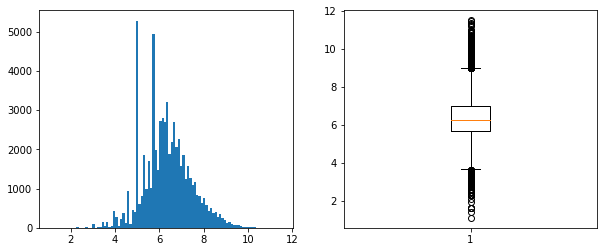

In [25]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(np.log(y_train), bins=100)

plt.subplot(1,2,2)
plt.boxplot(np.log(y_train))

plt.show()

### sigla_uf

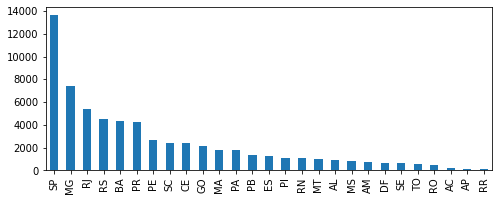

In [26]:
plt.figure(figsize=(8,3))
X_train['sigla_uf'].value_counts().plot(kind='bar')
plt.show()

In [30]:
rend_medio_uf = X_train.join(y_train)[['sigla_uf', 'rendimento']].groupby('sigla_uf').mean().sort_values(by='rendimento', ascending=False)
rend_medio_uf

,rendimento
sigla_uf,
DF,2148.245827
SP,1554.207518
RJ,1426.883182
RR,1225.631148
SC,1150.008589
RS,1144.054365
AP,1135.905512
PR,1104.173104
MT,1071.260155


In [34]:
geo_uf = gpd.read_file('data/geospatial/BR_UF_2021.shp')
geo_uf_rend_medio = geo_uf.merge(rend_medio_uf, left_on='SIGLA', right_on='sigla_uf')

/home/franklin/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


/home/franklin/.local/lib/python3.8/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/franklin/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


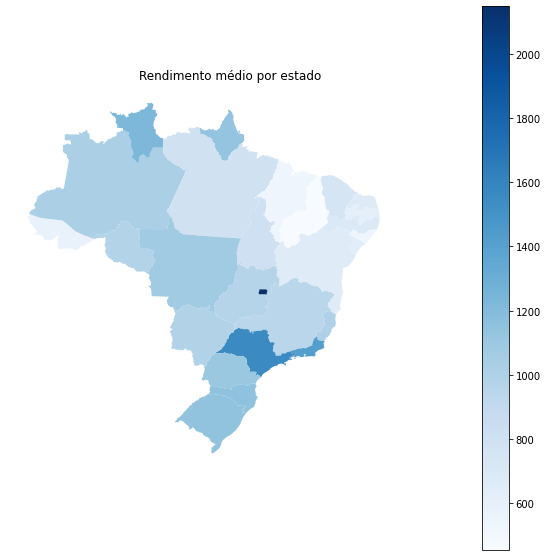

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
geo_uf_rend_medio.plot(column='rendimento', cmap='Blues', ax=ax, legend=True)
plt.title('Rendimento médio por estado')
plt.axis('off')
plt.show()

### situacao_domicilio

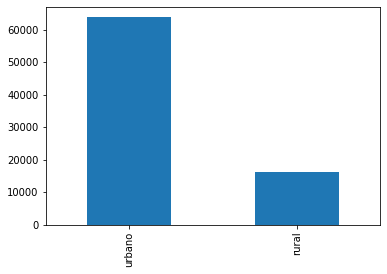

In [31]:
X_train['situacao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [32]:
X_train.join(y_train).groupby('situacao_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,televisores,automoveis,ar_condicionado,moradores,homens,mulheres,rendimento
situacao_domicilio,,,,,,,,,,
urbano,5.0,2.0,1.0,1.0,0.0,0.0,4.0,2.0,2.0,602.0
rural,5.0,2.0,1.0,1.0,0.0,0.0,4.0,2.0,2.0,300.0


### condicao_domicilio

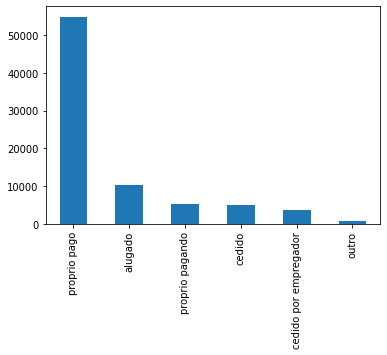

In [33]:
X_train['condicao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [34]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,microondas,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres
68111,RJ,urbano,casa,proprio pago,4,1,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,4,1,3
44812,PI,urbano,casa,proprio pago,6,2,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,4,1,3
76085,RJ,urbano,casa,alugado,2,1,1,outro,sim,sim,...,não,não,não,0,0,0,serviço de limpeza,1,1,0
37522,RS,urbano,casa,outro,3,2,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,5,1,4
11556,PE,urbano,casa,proprio pago,6,2,1,rede geral,sim,sim,...,não,não,não,2,0,0,serviço de limpeza,4,1,3


### tipo_domicilio

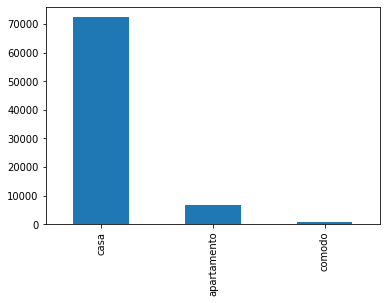

In [35]:
X_train['tipo_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [36]:
X_train.join(y_train).groupby('tipo_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,televisores,automoveis,ar_condicionado,moradores,homens,mulheres,rendimento
tipo_domicilio,,,,,,,,,,
apartamento,6.0,2.0,1.0,2.0,1.0,0.0,3.0,1.0,1.0,1800.0
casa,5.0,2.0,1.0,1.0,0.0,0.0,4.0,2.0,2.0,490.0
comodo,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,300.0


### comodos

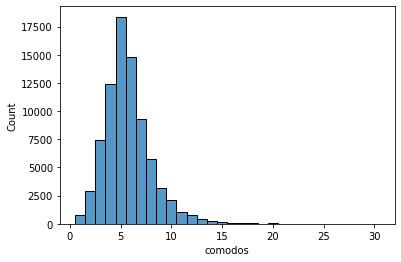

In [37]:
sns.histplot(data=X_train, x='comodos', discrete=True);

In [38]:
X_train['comodos'].describe()

count    80000.000000
mean         5.728413
std          2.359337
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         30.000000
Name: comodos, dtype: float64

### dormitorios

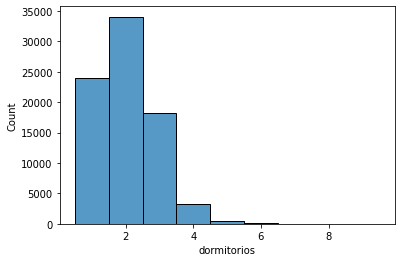

In [39]:
sns.histplot(data=X_train, x='dormitorios', discrete=True);

### banheiros

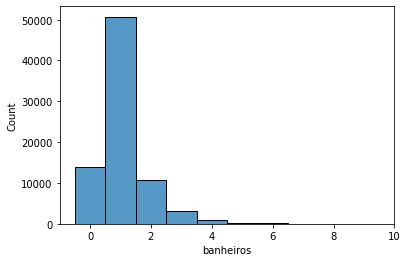

In [40]:
sns.histplot(data=X_train, x='banheiros', discrete=True);

### agua

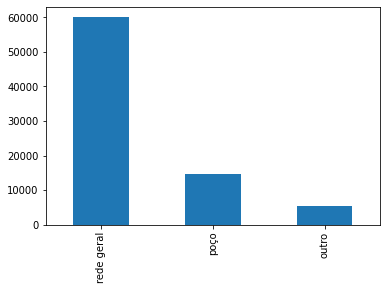

In [41]:
X_train['agua'].value_counts().plot(kind='bar')
plt.show()

### iluminacao

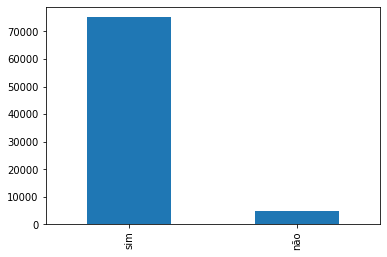

In [42]:
X_train['iluminacao'].value_counts().plot(kind='bar')
plt.show()

### radio

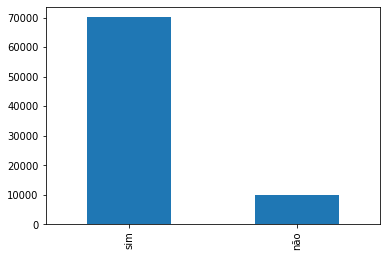

In [43]:
X_train['radio'].value_counts().plot(kind='bar')
plt.show()

### geladeira

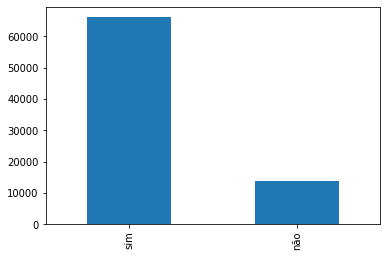

In [44]:
X_train['geladeira'].value_counts().plot(kind='bar')
plt.show()

### videocassete

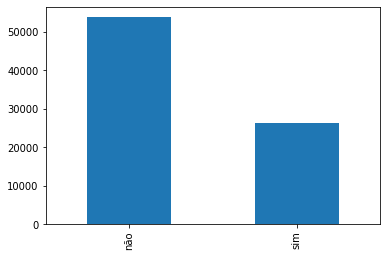

In [45]:
X_train['videocassete'].value_counts().plot(kind='bar')
plt.show()

### maquina_lavar

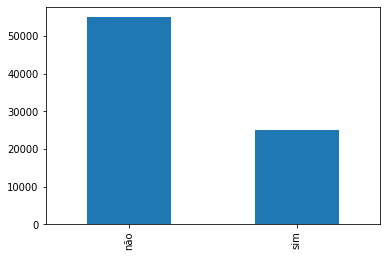

In [46]:
X_train['maquina_lavar'].value_counts().plot(kind='bar')
plt.show()

### microondas

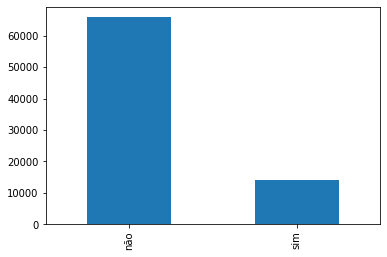

In [47]:
X_train['microondas'].value_counts().plot(kind='bar')
plt.show()

### telefone

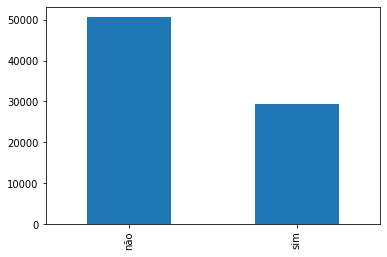

In [48]:
X_train['telefone'].value_counts().plot(kind='bar')
plt.show()

### computador

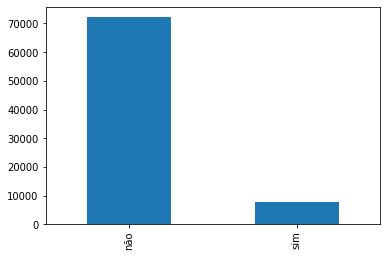

In [49]:
X_train['computador'].value_counts().plot(kind='bar')
plt.show()

### televisores

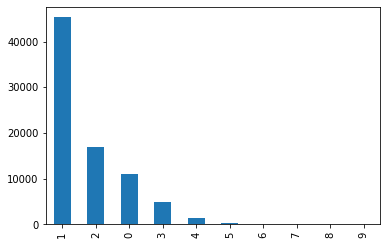

In [50]:
X_train['televisores'].value_counts().plot(kind='bar')
plt.show()

### automoveis

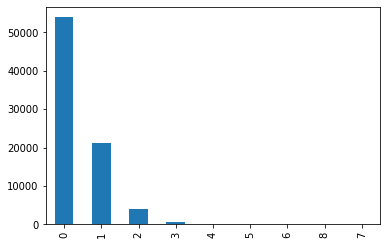

In [51]:
X_train['automoveis'].value_counts().plot(kind='bar')
plt.show()

### ar_condicionado

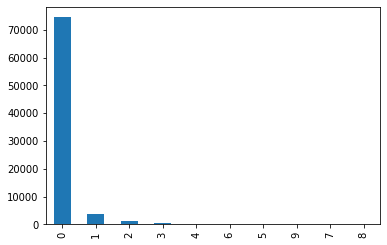

In [52]:
X_train['ar_condicionado'].value_counts().plot(kind='bar')
plt.show()

### coleta_lixo

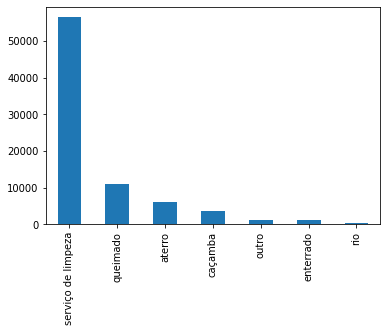

In [53]:
X_train['coleta_lixo'].value_counts().plot(kind='bar')
plt.show()

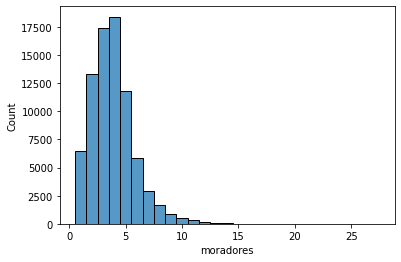

In [54]:
sns.histplot(data=X_train, x='moradores', discrete=True);

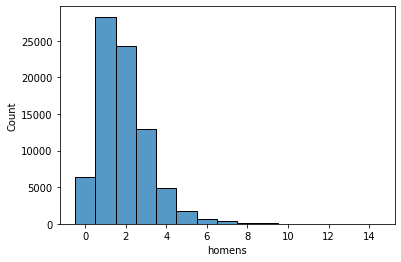

In [55]:
sns.histplot(data=X_train, x='homens', discrete=True);

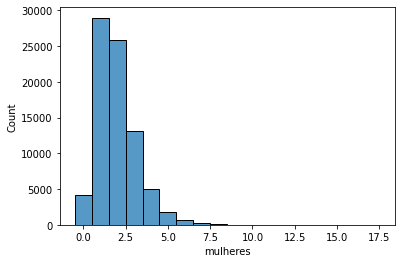

In [56]:
sns.histplot(data=X_train, x='mulheres', discrete=True);

## Correlações

rendimento         1.000000
automoveis         0.480357
banheiros          0.471861
televisores        0.424147
comodos            0.391006
ar_condicionado    0.324247
dormitorios        0.180411
mulheres           0.014766
moradores          0.013705
homens             0.006924
Name: rendimento, dtype: float64


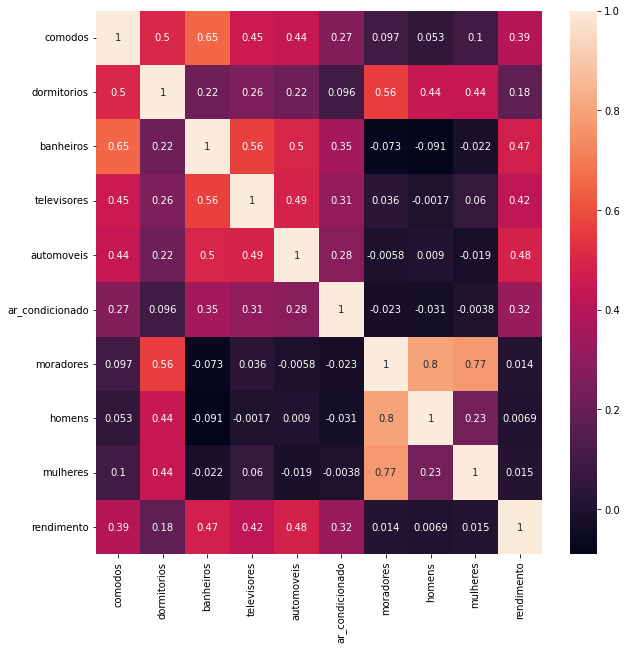

In [57]:
corr = X_train.join(y_train).corr()

plt.figure(figsize=(10,10))
sns.heatmap(data=corr, annot=True);

print(corr['rendimento'].sort_values(ascending=False))

## Baseline

In [58]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,microondas,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres
68111,RJ,urbano,casa,proprio pago,4,1,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,4,1,3
44812,PI,urbano,casa,proprio pago,6,2,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,4,1,3
76085,RJ,urbano,casa,alugado,2,1,1,outro,sim,sim,...,não,não,não,0,0,0,serviço de limpeza,1,1,0
37522,RS,urbano,casa,outro,3,2,1,rede geral,sim,sim,...,não,não,não,1,0,0,serviço de limpeza,5,1,4
11556,PE,urbano,casa,proprio pago,6,2,1,rede geral,sim,sim,...,não,não,não,2,0,0,serviço de limpeza,4,1,3


In [59]:
# Categorical and numerical features

cat_cols = list(X_train.select_dtypes('object').columns)
num_cols = list(X_train.select_dtypes('int64').columns)

In [60]:
# Transformers

ohe = OneHotEncoder(drop='first', sparse_output=False)
std_scaler = StandardScaler()
normalizer = Normalizer()
min_max_scaler = MinMaxScaler()

In [61]:
# Testando Normalizer

norm_pipeline = ColumnTransformer(transformers=[('cat', ohe, cat_cols),
                                                ('num', normalizer, num_cols)], 
                                                remainder='passthrough')


X_train_tr = norm_pipeline.fit_transform(X_train)
X_val_tr = norm_pipeline.transform(X_val)

forest_reg = RandomForestRegressor(random_state=42,
                                  n_jobs=-1)

forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))

MAE:  668.6737917643864
RMSE:  2119.942198754786


In [62]:
# Testando MinMaxScaler

minmax_pipeline = ColumnTransformer(transformers=[('cat', ohe, cat_cols),
                                                  ('num', min_max_scaler, num_cols)], 
                                                  remainder='passthrough')


X_train_tr = minmax_pipeline.fit_transform(X_train)
X_val_tr = minmax_pipeline.transform(X_val)

forest_reg = RandomForestRegressor(random_state=42,
                                  n_jobs=-1)

forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))

MAE:  654.0967526110761
RMSE:  2072.586379461122


In [63]:
# Testando StandardScaler

std_pipeline = ColumnTransformer(transformers=[('cat', ohe, cat_cols),
                                               ('num', std_scaler, num_cols)], 
                                               remainder='passthrough')


std_pipeline.set_output(transform="pandas")

X_train_tr = std_pipeline.fit_transform(X_train)
X_val_tr = std_pipeline.transform(X_val)

forest_reg = RandomForestRegressor(random_state=42,
                                  n_jobs=-1)

forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))

MAE:  653.3514749907491
RMSE:  2078.9416087545105


Os resultados com `StandardScaler` se mostraram promissores.

## Análises do erro

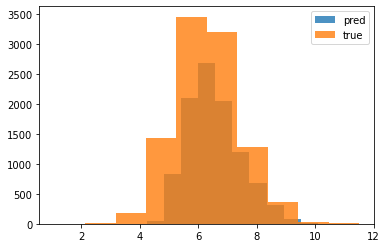

In [64]:
# Plotando a distribuição prevista com as de validação (usando log para visualização)

plt.hist(np.log(y_pred),alpha=0.8, label='pred')
plt.hist(np.log(y_val),alpha=0.8, label='true')
plt.legend()
plt.show()

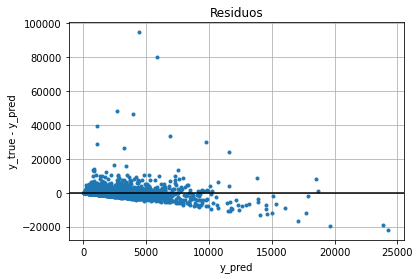

In [65]:
# Residuos

residues = y_val - y_pred

plt.plot(y_pred, residues, ls='', marker='.')
plt.axhline(c='k')
plt.xlabel('y_pred')
plt.ylabel('y_true - y_pred')
plt.title('Residuos')
plt.grid()
plt.show()

In [66]:
pd.Series(y_pred).describe()

count    10000.000000
mean      1119.681705
std       1530.697585
min         69.628333
25%        360.583125
50%        621.920952
75%       1204.177917
max      24282.270000
dtype: float64

In [67]:
y_train.describe()

count    80000.000000
mean      1081.719850
std       2127.363233
min          4.000000
25%        282.000000
50%        511.000000
75%       1082.000000
max      95500.000000
Name: rendimento, dtype: float64

In [68]:
# Feature importance

fi = pd.DataFrame(list(zip(X_train_tr.columns, forest_reg.feature_importances_)), 
                  columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).reset_index(drop=True)

fi

,Feature,Importance
0,num__banheiros,0.208245
1,num__automoveis,0.129338
2,num__comodos,0.084961
3,num__televisores,0.056322
4,cat__computador_sim,0.055317
5,num__moradores,0.042776
6,num__ar_condicionado,0.036888
7,num__mulheres,0.035413
8,num__dormitorios,0.033556
9,num__homens,0.033383


O nosso modelo não tem precisão para rendas muito altas.

# Tratamento dos dados

## Tratamento de outliers

In [69]:
# Método tradicional

y_train_tr = y_train.copy()

Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)

iqr = Q3 - Q1

upper_bound = iqr + (1.5 * iqr)
lower_bound = iqr - (1.5 * iqr)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  638.5617301655066


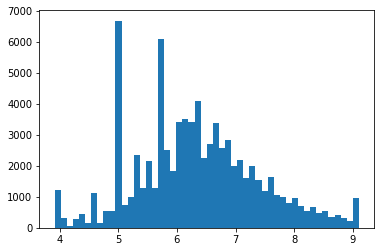

In [70]:
# Método alternativo

y_train_tr = y_train.copy()

upper_bound = np.percentile(y_train_tr, 99)
lower_bound = np.percentile(y_train_tr, 1)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

plt.hist(np.log(y_train_tr), bins=50)
plt.show()

In [71]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  583.2810681109321


## Feature engineering

In [72]:
X_train_feature = X_train.copy()
X_val_feature = X_val.copy()

In [73]:
X_train_feature['moradores_por_comodo'] = X_train['moradores'] / X_train['comodos']
X_train_feature['moradores_por_dormitorio'] = X_train['moradores'] / X_train['dormitorios']

X_val_feature['moradores_por_comodo'] = X_val['moradores'] / X_val['comodos']
X_val_feature['moradores_por_dormitorio'] = X_val['moradores'] / X_val['dormitorios']

In [75]:
X_train_feature_tr = std_pipeline.fit_transform(X_train_feature)
X_val_feature_tr = std_pipeline.transform(X_val_feature)

In [76]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  583.546819783836


# Refinando modelos

In [77]:
forest_reg = RandomForestRegressor(n_estimators=500,
                                   random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  581.434455560007


In [78]:
xgb_reg = XGBRegressor(n_estimators=500,
                       learning_rate=0.01,
                       n_jobs=-1,
                       random_state=42)

xgb_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = xgb_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  559.7548951499939


In [79]:
lgbm_reg = LGBMRegressor(n_estimators=300,
                         n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = lgbm_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  553.6834165161245


# Otimização de hiperparâmetros

In [80]:
# Random search

def treinar_modelo(params):
     
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    lgbm_reg = LGBMRegressor(n_estimators=500,
                             learning_rate=learning_rate,
                             num_leaves = num_leaves,
                             min_child_samples = min_child_samples,
                             subsample = subsample,
                             colsample_bytree = colsample_bytree,
                             subsample_freq=1,
                             n_jobs=-1, 
                             random_state=42)
    
    lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
    y_pred = lgbm_reg.predict(X_val_feature_tr)
    
    return mean_absolute_error(y_val, np.exp(y_pred))

space = [(1e-3, 1e-1), # learning_rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0) # colsample_bytree
        ]

resultado = dummy_minimize(treinar_modelo, space, random_state=42, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.07985775569916306, 16, 72, 0.6187255599871848, 0.2404167763981929]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.8503
Function value obtained: 552.0557
Current minimum: 552.0557
Iteration No: 2 started. Evaluating function at random point.
[0.016443457513284066, 76, 75, 0.8728673384861885, 0.6410035105688879]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.8619
Function value obtained: 552.0523
Current minimum: 552.0523
Iteration No: 3 started. Evaluating function at random point.
[0.07109918520180852, 23, 53, 0.9714143595538948, 0.8491983767203797]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.2346
Function value obtained: 552.5563
Current minimum: 552.0523
Iteration No: 4 started. Evaluating function at random point.
[0.022021571957149343, 65, 60, 0.22423428436076215, 0.373818018663584]
Iteration No: 4 ended. Evaluation done at random point.
Time ta

In [81]:
best_result = resultado.x

In [84]:
best_result

[0.024861521136575165, 61, 71, 0.6294968248934899, 0.849875420562548]

In [85]:
# Baysean optimization

np.int = int # GAMBIARRA

resultado = gp_minimize(treinar_modelo, space, random_state=42, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.07985775569916308, 25, 78, 0.6170076500491628, 0.5012494775682321]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2817
Function value obtained: 552.8177
Current minimum: 552.8177
Iteration No: 2 started. Evaluating function at random point.
[0.01089751666598229, 60, 34, 0.18572347702584374, 0.6857996256539677]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.4198
Function value obtained: 553.4815
Current minimum: 552.8177
Iteration No: 3 started. Evaluating function at random point.
[0.006584746323682927, 93, 94, 0.05073982754896361, 0.992990403362096]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.7341
Function value obtained: 566.6210
Current minimum: 552.8177
Iteration No: 4 started. Evaluating function at random point.
[0.06213066945314395, 79, 2, 0.07190930378934497, 0.5722971942325503]
Iteration No: 4 ended. Evaluation done at random point.
Time take

In [86]:
resultado.x

[0.038217691475179456, 31, 100, 0.5361182228972023, 0.41704320127104755]

# Resultados finais

In [87]:
lgbm_reg = LGBMRegressor(n_estimators=500,
                         learning_rate=0.08,
                         num_leaves=25,
                         min_child_samples = 80,
                         subsample = 0.6,
                         colsample_bytree=0.5,
                         subsample_freq=1,
                         n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))

y_pred = lgbm_reg.predict(X_val_feature_tr)

In [88]:
# Métricas de treino

mae = mean_absolute_error(y_val, np.exp(y_pred))
mape = mean_absolute_percentage_error(y_val, np.exp(y_pred))
rmse = np.sqrt(mean_squared_error(y_val, np.exp(y_pred)))
r2 = r2_score(y_val, np.exp(y_pred))

pd.DataFrame([{'Model':'LGBM (Treino)','MAE': mae, 'MAPE':mape, 'RMSE':rmse, 'R2':r2}])

,Model,MAE,MAPE,RMSE,R2
0,LGBM (Treino),552.696735,0.656123,2022.825477,0.27685


In [89]:
# Tratamento do teste

X_test_feature = X_test.copy()

In [91]:
# Métricas de teste

X_test_feature['moradores_por_comodo'] = X_test['moradores'] / X_test['comodos']
X_test_feature['moradores_por_dormitorio'] = X_test['moradores'] / X_test['dormitorios']


X_test_feature_tr = std_pipeline.transform(X_test_feature)

y_pred = lgbm_reg.predict(X_test_feature_tr)

mae = mean_absolute_error(y_test, np.exp(y_pred))
mape = mean_absolute_percentage_error(y_test, np.exp(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, np.exp(y_pred)))
r2 = r2_score(y_test, np.exp(y_pred))

pd.DataFrame([{'Model':'LGBM (Teste)','MAE': mae, 'MAPE':mape, 'RMSE':rmse, 'R2':r2}])

,Model,MAE,MAPE,RMSE,R2
0,LGBM (Teste),504.379133,0.645693,1283.783066,0.462776


In [93]:
# Intevalo de confiança

from scipy import stats

confidence = 0.95
absolute_errors = np.abs(np.exp(y_pred) - y_test)
stats.t.interval(confidence, len(absolute_errors)-1,
                loc=absolute_errors.mean(),
                scale=stats.sem(absolute_errors))

(481.236800556961, 527.5214658766733)